Assumes you have run `Train_Testset.ipynb` first to make the `alldata`, `realdist`, and `balanced` train/test splits for the chosen language pair.

# Imports and setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import panphon
import panphon.distance
import editdistance # levenshtein
import epitran
import eng_to_ipa as eng
from epitran.backoff import Backoff
from googletrans import Translator
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
epitran.download.cedict()

In [2]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import torch
from torch import nn
from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline

In [3]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import numpy as np 
import io
import requests
import csv

In [4]:
# transformer specific imports 
import sys
import json
import torch
from torch import nn
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup,\
    BertForSequenceClassification, BertForPreTraining, AutoModel
from transformers import XLMTokenizer, XLMWithLMHeadModel, XLMModel

from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import random
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, mean_squared_error
import time
from transformers import XLMTokenizer, XLMWithLMHeadModel

In [5]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
#device = torch.device("cuda:0:3" if torch.cuda.is_available() else "cpu") ## specify the GPU id's, GPU id's start from 0.

Using device: cuda

NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3090


# DNN Definition

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            
        )
        self.dropout = nn.Dropout(0.1) 

    def forward(self, x):
        logits_new = self.linear_relu_stack(x)
        logits  = self.dropout(logits_new)
        
        return torch.sigmoid(logits), logits_new
    
    def fit(self, X_train, Y_train, X_val, Y_val, criterion, optimizer, n_epochs=5000):
        train_losses = []
        val_losses = []
        train_accur = []
        val_accur = []

        for epoch in range(n_epochs):
            y_pred, logits = self(X_train.float())

            train_loss = criterion(y_pred, Y_train.float())

            if epoch % (n_epochs // 50) == 0:
                train_acc,_ = self.calculate_accuracy(Y_train, y_pred)

                y_val_pred = self(X_val.float())[0]

                val_loss = criterion(y_val_pred, Y_val.float())

                val_acc, total_corr = self.calculate_accuracy(Y_val, y_val_pred)

                print(f'''epoch {epoch}
                    Train set - loss: {self.round_tensor(train_loss)}, accuracy: {self.round_tensor(train_acc)} 
                    Val set - loss: {self.round_tensor(val_loss)}, accuracy: {self.round_tensor(val_acc)}''')
                
                train_losses.append(train_loss.detach().cpu().numpy())
                val_losses.append(val_loss.detach().cpu().numpy())

                val_accur.append(val_acc.detach().cpu().numpy())
                train_accur.append(train_acc.detach().cpu().numpy())

            optimizer.zero_grad()

            train_loss.backward()

            optimizer.step()
            
        return train_losses,val_losses,train_accur,val_accur
    
    def calculate_accuracy(self, y_true, y_pred):
        predicted = y_pred.ge(.5) 
        return ((y_true == predicted).sum().float() / len(y_true), (y_true == predicted).sum())
    
    def round_tensor(self, t, decimal_places=3):
        return round(t.item(), decimal_places)
    
    def plot_losses(self, train_losses, val_losses, train_accur, val_accur):
        epochs = range(1, len(train_accur) + 1)

        plt.plot(epochs, train_accur, 'bo', label='Training acc')
        plt.plot(epochs, val_accur, 'b', label='Vaidation acc')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.figure()

        plt.plot(epochs, train_losses, 'bo', label='Training loss')
        plt.plot(epochs, val_losses, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

# MyDataset definition

In [8]:
# Overriding the Dataset class required for the use of PyTorch's data loader classes.
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, l1_encodings, l2_encodings):
        self.l1_encodings = l1_encodings
        self.l2_encodings = l2_encodings

    def __getitem__(self, idx):
        item = {('l1_' + key): torch.tensor(val[idx]) for key, val in self.l1_encodings.items()}
        item2 = {('l2_' + key): torch.tensor(val[idx]) for key, val in self.l2_encodings.items()}
        item.update(item2)
        # item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.l1_encodings['attention_mask'])

# Download LMs

In [9]:
xlm_tokenizer = XLMTokenizer.from_pretrained("xlm-mlm-100-1280")
xlm_model = XLMModel.from_pretrained("xlm-mlm-100-1280")

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
xlm_model

XLMModel(
  (position_embeddings): Embedding(512, 1280)
  (embeddings): Embedding(200000, 1280, padding_idx=2)
  (layer_norm_emb): LayerNorm((1280,), eps=1e-12, elementwise_affine=True)
  (attentions): ModuleList(
    (0): MultiHeadAttention(
      (q_lin): Linear(in_features=1280, out_features=1280, bias=True)
      (k_lin): Linear(in_features=1280, out_features=1280, bias=True)
      (v_lin): Linear(in_features=1280, out_features=1280, bias=True)
      (out_lin): Linear(in_features=1280, out_features=1280, bias=True)
    )
    (1): MultiHeadAttention(
      (q_lin): Linear(in_features=1280, out_features=1280, bias=True)
      (k_lin): Linear(in_features=1280, out_features=1280, bias=True)
      (v_lin): Linear(in_features=1280, out_features=1280, bias=True)
      (out_lin): Linear(in_features=1280, out_features=1280, bias=True)
    )
    (2): MultiHeadAttention(
      (q_lin): Linear(in_features=1280, out_features=1280, bias=True)
      (k_lin): Linear(in_features=1280, out_features=

# Pipeline function definitions

## Get Panphon phonetic features

In [11]:
def get_panphon_features(train_set, test_set):
    #get phonetic features using PanPhon
    ft = panphon.FeatureTable()   
    
    train_set['features_loan'] = train_set.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
    train_set['features_orig'] = train_set.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)
    test_set['features_loan'] = test_set.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
    test_set['features_orig'] = test_set.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)

    train_set['features_loan'] = train_set['features_loan'].apply(lambda x:sum(x, []))
    train_set['features_orig'] = train_set['features_orig'].apply(lambda x:sum(x, []))
    test_set['features_orig'] = test_set['features_orig'].apply(lambda x:sum(x, []))
    test_set['features_loan'] = test_set['features_loan'].apply(lambda x:sum(x, []))

In [12]:
def pad_panphon_features(train_set, test_set, maxlen, verbose=False):
    # Pad the phonetic features of the loan word and original word out to the maxlen 
    # of the features appearing in the training set (format: `<loan><pad 0s><orig><pad 0s>`).
    train_set['features_loan'] = train_set['features_loan'].apply(lambda x: \
                                    np.pad(x,\
                                    (0,maxlen[0]-len(x)), 'constant'))
    train_set['features_orig'] = train_set['features_orig'].apply(lambda x: \
                                    np.pad(x,\
                                    (0,maxlen[1]-len(x)), 'constant'))
    test_set['features_loan'] = test_set['features_loan'].apply(lambda x: \
                                    np.pad(x,\
                                    (0,maxlen[0]-len(x)), 'constant'))
    test_set['features_orig'] = test_set['features_orig'].apply(lambda x: \
                                    np.pad(x,\
                                    (0,maxlen[1]-len(x)), 'constant'))
    
    if verbose:
        print("Sample train features:\n",\
                train_set['features_loan'][np.random.randint(len(train_set['features_loan']))],\
                train_set['features_orig'][np.random.randint(len(train_set['features_loan']))])

        print("Sample test features:\n",\
                test_set['features_loan'][np.random.randint(len(test_set['features_loan']))],\
                test_set['features_orig'][np.random.randint(len(test_set['features_orig']))])
    

## Add target labels and make train and validation sets

In [13]:
def add_target_labels(train_set, test_set):
    Y_train = np.array([y for y in train_set['label_bin']])
    Y_test = np.array([y for y in test_set['label_bin']])
    return Y_train, Y_test

Make a validation split for training the DNN model

In [14]:
def make_train_val_set(train_set, test_set, Y_train):
    X_train = np.hstack([np.array([x for x in train_alldata['features_loan']]),\
                np.array([x for x in train_alldata['features_orig']])])
    X_test = np.hstack([np.array([x for x in test_alldata['features_loan']]),\
                np.array([x for x in test_alldata['features_orig']])])
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2,\
                                                      random_state=1, stratify=Y_train)
    return X_train, X_val, X_test, Y_train, Y_val

Make tensors

In [15]:
def make_tensors(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    X_train = torch.tensor(X_train).to(device)
    Y_train = torch.tensor(Y_train).to(device).reshape((-1,1))

    X_val = torch.tensor(X_val).to(device)
    Y_val = torch.tensor(Y_val).to(device).reshape((-1,1))
    
    X_test = torch.tensor(X_test).to(device)
    Y_test = torch.tensor(Y_test).to(device).reshape((-1,1))
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

## Get cosine similarities

MBERT

In [16]:
def get_mbert_cos_sims(l1_data,l2_data):
    with torch.no_grad():
        tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_bert_MODEL)
        tokenizer.model_max_length = MAXTOKENS
        l1_encodings = tokenizer(l1_data, truncation=False, padding=True, max_length=MAXTOKENS)
        l2_encodings = tokenizer(l2_data, truncation=False, padding=True, max_length=MAXTOKENS)
        
        dataset = MyDataset(l1_encodings, l2_encodings)
        
        data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
        
        base_model = BertModel.from_pretrained(PRE_TRAINED_bert_MODEL).to(device)
        base_model.eval()
        cos_s = torch.nn.CosineSimilarity()
        
        sim_lst = []
        
        #loop through dataset 
        for step, batch in enumerate(data_loader):
            l1_vector = base_model(batch['l1_input_ids'].to(device),
                                          attention_mask=batch['l1_attention_mask'].to(device),
                                          return_dict=True).last_hidden_state[:, 0, :]
            l2_vector = base_model(batch['l2_input_ids'].to(device),
                                          attention_mask=batch['l2_attention_mask'].to(device),
                                          return_dict=True).last_hidden_state[:, 0, :]
            sims = cos_s(l1_vector, l2_vector).data.cpu().numpy()
            sim_lst.extend(list(sims))
            if (step * BS) % 100 < BS:
                print("Got {}".format(len(sim_lst)))
        print()
                
    return sim_lst

XLM-100

In [17]:
def get_xlm_cos_sims(l1_data,l2_data):
    with torch.no_grad():
        tokenizer = XLMTokenizer.from_pretrained(PRE_TRAINED_xlm_MODEL)
        tokenizer.model_max_length = MAXTOKENS 
        l1_encodings = tokenizer(l1_data, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask=True)
        l2_encodings = tokenizer(l2_data, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask=True)

        dataset = MyDataset(l1_encodings, l2_encodings)

        data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility

        
        base_model = XLMModel.from_pretrained(PRE_TRAINED_xlm_MODEL).to(device)
        
        base_model.eval()
        cos_s = torch.nn.CosineSimilarity()
        
        sim_lst = []

        #loop through dataset 
        for step, batch in enumerate(data_loader):
            
            l1_vector = base_model(batch['l1_input_ids'].to(device), output_hidden_states=False).last_hidden_state
            l2_vector = base_model(batch['l2_input_ids'].to(device), output_hidden_states=False).last_hidden_state 
            
            sims = cos_s(l1_vector[:,0,:],l2_vector[:,0,:]).data.cpu().numpy()
            sim_lst.extend(list(sims))
            if (step * BS) % 100 < BS:
                print("Got {}".format(len(sim_lst)))
        print()
                
    return sim_lst 

# Load `language-pairs.json` list and run pipeline for each

In [18]:
pairs = None

with open('../language-pairs.json', 'r') as f: # for getting logits from all languages
 
    
    pairs = json.loads(f.read())
for pair in pairs:
    print(pair)

Hindi-Persian
English-French
Finnish-Swedish
Kazakh-Russian
Azerbaijani-Arabic
Chinese-English
German-French
English-German
Romanian-Hungarian
Polish-French
Indonesian-Dutch
Romanian-French


In [19]:
pairs = None

with open('../language-pairs-holdout.json', 'r') as f: # for getting logits from all languages
 
    
    pairs = json.loads(f.read())
for pair in pairs:
    print(pair)

Persian-Arabic
Hungarian-German
German-Italian
Catalan-Arabic


Hindi-Persian

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1296, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.658, accuracy: 0.817 
                    Val set - loss: 0.658, accuracy: 0.813
epoch 100
                    Train set - loss: 0.451, accuracy: 0.819 
                    Val set - loss: 0.456, accuracy: 0.807
epoch 200
                    Train set - loss: 0.351, accuracy: 0.819 
                    Val set - loss: 0.351, accuracy: 0.817
epoch 300
                    Train set - loss: 0.338, accuracy: 0.825 
                    Val set - loss: 0.346, accuracy: 0.823
epoch 400
                    Train set - loss: 0.336, accuracy: 0.821 
                    Val set - loss: 0.342, accuracy: 0

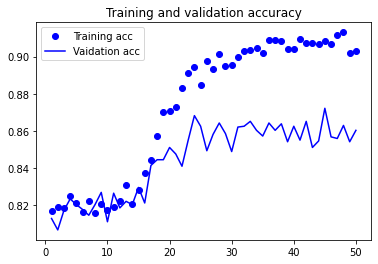

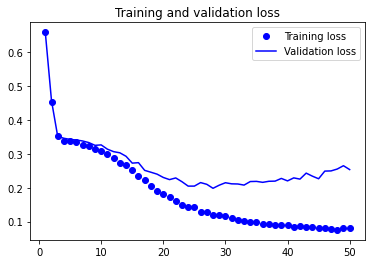

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208

English-French

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1080, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.705, accuracy: 0.263 
                    Val set - loss: 0.705, accuracy: 0.261
epoch 100
                    Train set - loss: 0.499, accuracy: 0.781 
                    Val set - loss: 0.497, accuracy: 0.787
epoch 200
                    Train set - loss: 0.443, accuracy: 0.785 
                    Val set - loss: 0.445, accuracy: 0.785
epoch 300
                    Train set - loss: 0.437, accuracy: 0.783 
                    Val set - loss: 0.436, accuracy: 0.786
epoch 400
         

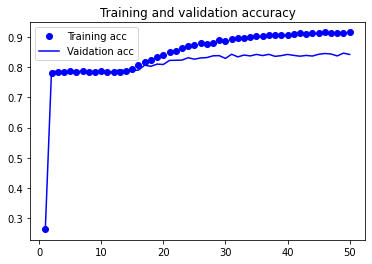

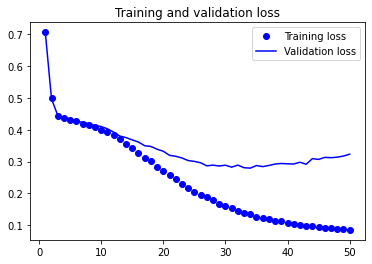

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408

Finnish-Swedish

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1008, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.665, accuracy: 0.812 
                    Val set - loss: 0.665, accuracy: 0.809
epoch 100
                    Train set - loss: 0.414, accuracy: 0.825 
                    Val set - loss: 0.414, accuracy: 0.832
epoch 200
                    Train set - loss: 0.334, accuracy: 0.827 
          

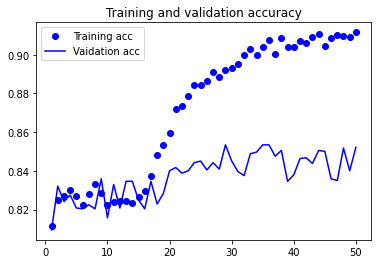

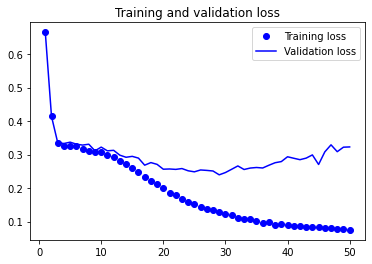

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312

Kazakh-Russian

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1224, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.669, accuracy: 0.801 
                    Val set - loss: 0.668, accuracy: 0.812
epoch 100
                    Train set - loss: 0.444, accuracy: 0.805 
                    Val set - loss: 0.438, accuracy: 0.817
epoch 200
                    Train set - loss: 0.388, accuracy: 0.812 
                    Val set - loss: 0.388, accuracy: 0.816
epoch 300
                    Train set - loss: 0.375, accuracy: 0.812 
                    Val set - loss: 0.383, accuracy: 0.804
epoch 400


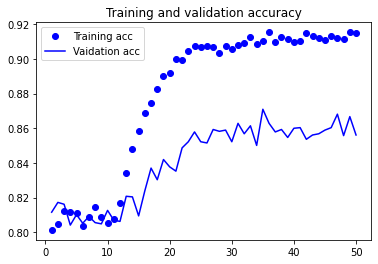

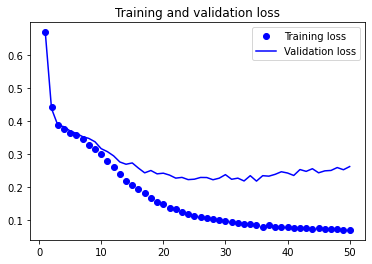

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512

Azerbaijani-Arabic

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=840, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.701, accuracy: 0.289 
                    Val set - loss: 0.702, accuracy: 0.266
epoch 100
                    Train set - loss: 0.474, accuracy: 0.826 
                    Val set - loss: 0.473, accuracy: 0.825
epoch 200
                    Train set - loss: 0.34, accuracy: 0.832 
                    Val set - loss: 0.337, accuracy: 0.833
epoch 300
                    Train set - loss: 0.327, accuracy: 0.832 
                    Val set - loss: 0.326, accura

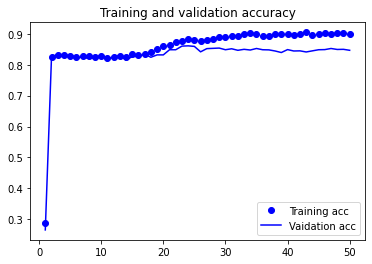

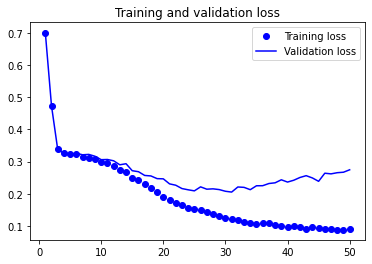

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008



Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008



Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208

Chinese-English

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=816, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.711, accuracy: 0.14 
                    Val set - loss: 0.711, accuracy: 0.149
epoch 100
                    Train set - loss: 0.474, accuracy: 0.816 
                    Val set - loss: 0.467, accuracy: 0.83
epoch 200
                    Train set - loss: 0.367, accuracy: 0.826 
                    Val set - loss: 0.368, accuracy: 0.816
epoch 300
                    Train set - loss: 0.36, accuracy: 0.82 
                    Val set - loss: 0.357, accuracy: 0.819
epoch 400
             

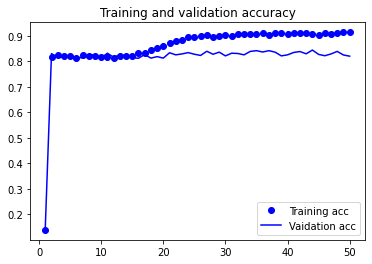

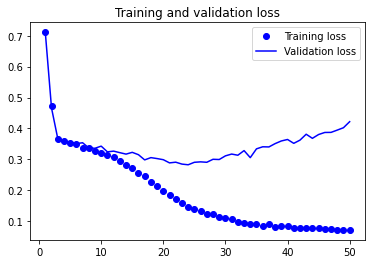

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512



Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512



Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912

German-French

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1008, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.666, accuracy: 0.805 
                    Val set - loss: 0.667, accuracy: 0.807
epoch 100
                    Train set - loss: 0.431, accuracy: 0.816 
                    Val set - loss: 0.425, accuracy: 0.827
epoch 200
                    Train set - loss: 0.366, accuracy: 0.82 
                    Val set - loss: 0.367, accuracy: 0.814
epoch 300
                    Train set - loss: 0.357, accuracy: 0.823 
                    Val set - loss: 0.361, accuracy: 0.819
epoch 400
                    Train set - loss: 

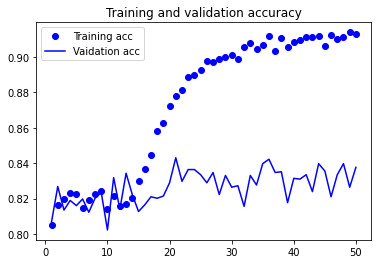

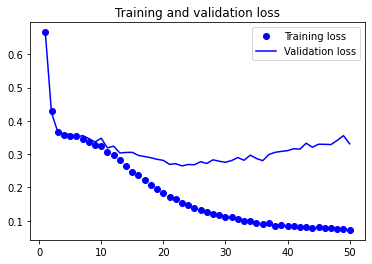

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312

English-German

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1248, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.695, accuracy: 0.412 
                    Val set - loss: 0.695, accuracy: 0.417
epoch 100
                    Train set - loss: 0.489, accuracy: 0.789 
                    Val set - loss: 0.484, accuracy: 0.794
epoch 200
                    Train set - loss: 0.425, accuracy: 0.795 
                    Val set - loss: 0.422, accuracy: 0.793
epoch 300
                    Train set - loss: 0.419, accuracy: 0.793 
                    Val set - loss: 0.415, accuracy: 0.796
epoch 400


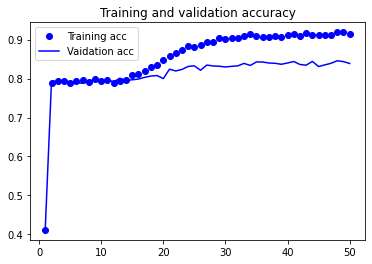

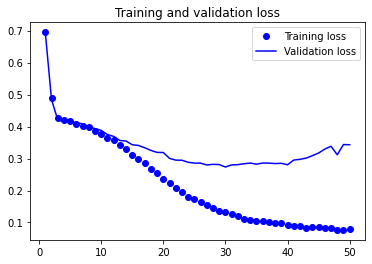

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2207


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2207

Romanian-Hungarian

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=984, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.725, accuracy: 0.111 
                    Val set - loss: 0.725, accuracy: 0.111
epoch 100
                    Train set - loss: 0.465, accuracy: 0.812 
                    Val set - loss: 0.466, accuracy: 0.809
epoch 200
                    Train set - loss: 0.368, accuracy: 0.815 
                    Val set - loss: 0.363, accuracy: 0.822
epoch 300
                    Train set - loss: 0.36, acc

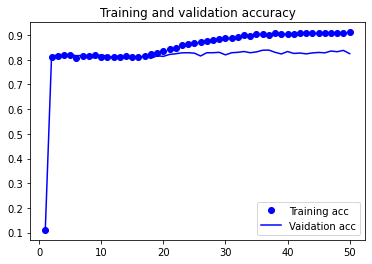

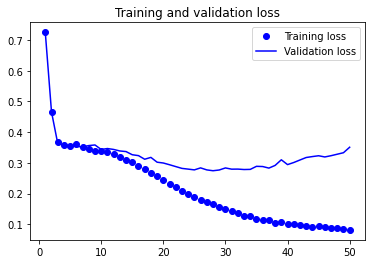

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312

Polish-French

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=984, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.724, accuracy: 0.127 
                    Val set - loss: 0.723, accuracy: 0.128
epoch 100
                    Train set - loss: 0.477, accuracy: 0.8 
                    Val set - loss: 0.47, accuracy: 0.812
epoch 200
                    Train set - loss: 0.414, accuracy: 0.803 
                    Val set - loss: 0.411, accuracy: 0.8
epoch 300
                    Train set - loss: 0.407, accuracy: 0.801 
                    Val set - loss: 0.405, accuracy: 0.802
epoch 400
       

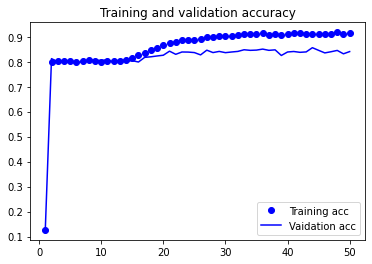

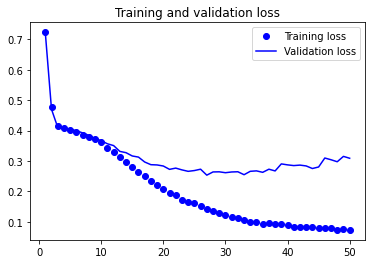

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608

Indonesian-Dutch

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=960, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.687, accuracy: 0.6 
                    Val set - loss: 0.687, accuracy: 0.621
epoch 100
                    Train set - loss: 0.48, accuracy: 0.791 
                    Val set - loss: 0.485, accuracy: 0.784
epoch 200
                    Train set - loss: 0.425, accuracy: 0.794 
                    Val set - loss: 0.426, accuracy: 0.799
epoch 300
                    Train set - loss: 0.419, accuracy: 0.792 
                    Val set - loss: 0.42, ac

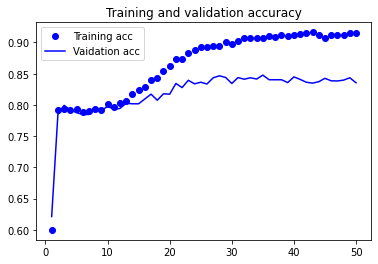

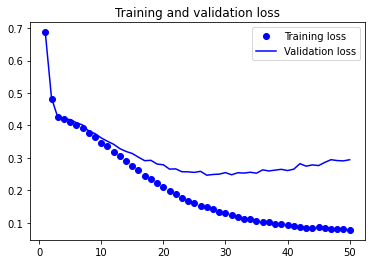

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912

Romanian-French

Using cuda device

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=984, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
) 

epoch 0
                    Train set - loss: 0.723, accuracy: 0.125 
                    Val set - loss: 0.724, accuracy: 0.124
epoch 100
                    Train set - loss: 0.473, accuracy: 0.8 
                    Val set - loss: 0.474, accuracy: 0.804
epoch 200
                    Train set - loss: 0.41, accuracy: 0.808 
                    Val set - loss: 0.421, accuracy: 0.804
epoch 300
                    Train set - loss: 0.402, accuracy: 0.807 
                  

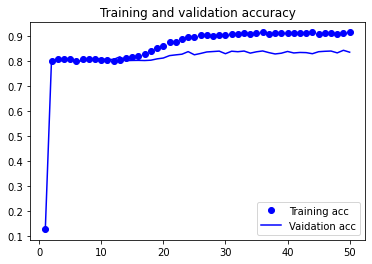

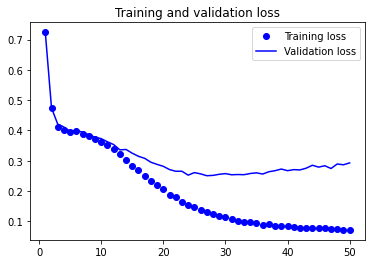

Getting logits from DNN
Getting MBERT similarities


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2280: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608


Getting XLM similarities


Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy const

Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608
Got 1712
Got 1808
Got 1912
Got 2008
Got 2112
Got 2208
Got 2312
Got 2408
Got 2512
Got 2608
Got 2712
Got 2808
Got 2912
Got 3008
Got 3112
Got 3208
Got 3312
Got 3408
Got 3512
Got 3608
Got 3712
Got 3808
Got 3912
Got 4008
Got 4112
Got 4208
Got 4312
Got 4408
Got 4512
Got 4608
Got 4712
Got 4808
Got 4912
Got 5008
Got 5112
Got 5208
Got 5312
Got 5408
Got 5512
Got 5608
Got 5712
Got 5808
Got 5912
Got 6008
Got 6112
Got 6208
Got 6312
Got 6408
Got 6512
Got 6608
Got 6712
Got 6808
Got 6912
Got 7008
Got 7112
Got 7208
Got 7312
Got 7408
Got 7512
Got 7608
Got 7712
Got 7808
Got 7912
Got 8008
Got 8112
Got 8208
Got 8312
Got 8408
Got 8512
Got 8608
Got 8712
Got 8808
Got 8912
Got 9008
Got 9112
Got 9208
Got 9312
Got 9408
Got 9512
Got 9608
Got 9712
Got 9808
Got 9912
Got 10008
Got 10112
Got 10208
Got 10312
Got 10408
Got 10512
Got 10608
Got 10712
Got 10808
Got 10912
Got 11008
Go

Some weights of the model checkpoint at xlm-mlm-100-1280 were not used when initializing XLMModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Got 8
Got 112
Got 208
Got 312
Got 408
Got 512
Got 608
Got 712
Got 808
Got 912
Got 1008
Got 1112
Got 1208
Got 1312
Got 1408
Got 1512
Got 1608



In [20]:
pairs = None

with open('../language-pairs.json', 'r') as f:
    pairs = json.loads(f.read())

for pair in pairs:
    print(pair)
    L1 = pairs[pair]['target']['name']
    L2 = pairs[pair]['source']['name']
    
    # load datasets
    prefix = f'../Datasets/production_train_test/{L1}-{L2}'
    
    train_alldata = pd.read_csv(f'{prefix}/alldata/{L1}-{L2}-train_production_alldata.csv')
    test_alldata = pd.read_csv(f'{prefix}/alldata/{L1}-{L2}-test_production_alldata.csv')

    train_realdist = pd.read_csv(f'{prefix}/realdist/{L1}-{L2}-train_production_realdist.csv')
    test_realdist = pd.read_csv(f'{prefix}/realdist/{L1}-{L2}-test_production_realdist.csv')

    train_balanced = pd.read_csv(f'{prefix}/balanced/{L1}-{L2}-train_production_balanced.csv')
    test_balanced = pd.read_csv(f'{prefix}/balanced/{L1}-{L2}-test_production_balanced.csv')

    # get and pad PanPhon features for alldata split
    get_panphon_features(train_alldata, test_alldata)
    alldata_maxlen = (max(np.max(train_alldata['features_loan'].str.len()),\
                          np.max(test_alldata['features_loan'].str.len())),\
                      max(np.max(train_alldata['features_orig'].str.len()),\
                          np.max(test_alldata['features_orig'].str.len())))
    pad_panphon_features(train_alldata, test_alldata, alldata_maxlen)

    # add target labels
    Y_train, Y_test = add_target_labels(train_alldata, test_alldata)

    # make train and val splits
    X_train, X_val, X_test, Y_train, Y_val = make_train_val_set(train_alldata, test_alldata, Y_train)
    X_train, Y_train, X_val, Y_val, X_test, Y_test = make_tensors(X_train, Y_train, X_val, Y_val, X_test, Y_test)

    # instantiate network
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"\nUsing {device} device\n")
    
    # set random seeds for reproducibility
    np.random.seed(666)

    model = NeuralNetwork(X_train.shape[1]).to(device)
    print(model,"\n")

    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    # train and plot losses, accuracy
    train_losses, val_losses, train_accur, val_accur = \
        model.fit(X_train, Y_train, X_val, Y_val, criterion, optimizer)
    model.plot_losses(train_losses,val_losses,train_accur,val_accur)

    # get and pad PanPhon features for realdist and balanced splits
    get_panphon_features(train_realdist,test_realdist)
    pad_panphon_features(train_realdist,test_realdist,alldata_maxlen)

    get_panphon_features(train_balanced,test_balanced)
    pad_panphon_features(train_balanced,test_balanced,alldata_maxlen)

    # create data to get logits for
    X_train_alldata = torch.tensor(np.hstack([np.array([x for x in train_alldata['features_loan']]),\
                         np.array([x for x in train_alldata['features_orig']])])).to(device)
    X_test_alldata = torch.tensor(np.hstack([np.array([x for x in test_alldata['features_loan']]),\
                        np.array([x for x in test_alldata['features_orig']])])).to(device)

    X_train_realdist = torch.tensor(np.hstack([np.array([x for x in train_realdist['features_loan']]),\
                         np.array([x for x in train_realdist['features_orig']])])).to(device)
    X_test_realdist = torch.tensor(np.hstack([np.array([x for x in test_realdist['features_loan']]),\
                        np.array([x for x in test_realdist['features_orig']])])).to(device)

    X_train_balanced = torch.tensor(np.hstack([np.array([x for x in train_balanced['features_loan']]),\
                         np.array([x for x in train_balanced['features_orig']])])).to(device)
    X_test_balanced = torch.tensor(np.hstack([np.array([x for x in test_balanced['features_loan']]),\
                        np.array([x for x in test_balanced['features_orig']])])).to(device)

    # place model in eval mode and get logits from DNN for all datasets/splits
    print("Getting logits from DNN")
    model.eval()

    with torch.no_grad():
        train_logits_dnn_alldata = model(X_train_alldata.float())[1].detach().cpu().numpy()
        test_logits_dnn_alldata = model(X_test_alldata.float())[1].detach().cpu().numpy()
        train_logits_dnn_realdist = model(X_train_realdist.float())[1].detach().cpu().numpy()
        test_logits_dnn_realdist = model(X_test_realdist.float())[1].detach().cpu().numpy()
        train_logits_dnn_balanced = model(X_train_balanced.float())[1].detach().cpu().numpy()
        test_logits_dnn_balanced = model(X_test_balanced.float())[1].detach().cpu().numpy()

    # remove PanPhon features from dataframe and add logits column
    train_alldata = train_alldata.drop(['features_loan','features_orig'], axis=1)
    train_alldata['DNN_logits'] = train_logits_dnn_alldata

    test_alldata = test_alldata.drop(['features_loan','features_orig'], axis=1)
    test_alldata['DNN_logits'] = test_logits_dnn_alldata

    train_realdist = train_realdist.drop(['features_loan','features_orig'], axis=1)
    train_realdist['DNN_logits'] = train_logits_dnn_realdist

    test_realdist = test_realdist.drop(['features_loan','features_orig'], axis=1)
    test_realdist['DNN_logits'] = test_logits_dnn_realdist

    train_balanced = train_balanced.drop(['features_loan','features_orig'], axis=1)
    train_balanced['DNN_logits'] = train_logits_dnn_balanced

    test_balanced = test_balanced.drop(['features_loan','features_orig'], axis=1)
    test_balanced['DNN_logits'] = test_logits_dnn_balanced

    #set the seeds for reproducibility even though we are not fine-tuning or training and the weights 
    #for both these models are effectively frozen for our purpose 
    torch.manual_seed(7)
    random.seed(7)
    np.random.seed(7)

    # Setting PyTorch's required configuration variables for reproducibility.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = False
    torch.use_deterministic_algorithms(False)

    PRE_TRAINED_bert_MODEL = 'bert-base-multilingual-cased'
    PRE_TRAINED_xlm_MODEL = 'xlm-mlm-100-1280'

    MAXTOKENS = 5
    BS = 8  # batch size

    #list of loan-original words for train sets
    l1_train_alldata = list(train_alldata["loan_word"])
    l2_train_alldata = list(train_alldata["original_word"])

    l1_train_realdist = list(train_realdist["loan_word"])
    l2_train_realdist = list(train_realdist["original_word"])

    l1_train_balanced = list(train_balanced["loan_word"])
    l2_train_balanced = list(train_balanced["original_word"])

    #list of loan-original words for test sets
    l1_test_alldata = list(test_alldata["loan_word"])
    l2_test_alldata = list(test_alldata["original_word"])

    l1_test_realdist = list(test_realdist["loan_word"])
    l2_test_realdist = list(test_realdist["original_word"])

    l1_test_balanced = list(test_balanced["loan_word"])
    l2_test_balanced = list(test_balanced["original_word"])

    print("Getting MBERT similarities")
    train_alldata['MBERT_cos_sim'] = get_mbert_cos_sims(l1_train_alldata,l2_train_alldata)
    test_alldata['MBERT_cos_sim'] = get_mbert_cos_sims(l1_test_alldata,l2_test_alldata)

    train_realdist['MBERT_cos_sim'] = train_realdist.merge(pd.concat([train_alldata,test_alldata]),\
                                                           on=['loan_word','original_word'], how="left")['MBERT_cos_sim']
    train_balanced['MBERT_cos_sim'] = train_balanced.merge(pd.concat([train_alldata,test_alldata]),\
                                                           on=['loan_word','original_word'], how="left")['MBERT_cos_sim']

    test_realdist['MBERT_cos_sim'] = test_realdist.merge(pd.concat([train_alldata,test_alldata]),\
                                                         on=['loan_word','original_word'], how="left")['MBERT_cos_sim']
    test_balanced['MBERT_cos_sim'] = test_balanced.merge(pd.concat([train_alldata,test_alldata]),\
                                                         on=['loan_word','original_word'], how="left")['MBERT_cos_sim']

    print()
    print("Getting XLM similarities")
    train_alldata['XLM_cos_sim'] = get_xlm_cos_sims(l1_train_alldata,l2_train_alldata)
    test_alldata['XLM_cos_sim'] = get_xlm_cos_sims(l1_test_alldata,l2_test_alldata)

    train_realdist['XLM_cos_sim'] = train_realdist.merge(pd.concat([train_alldata,test_alldata]),\
                                                           on=['loan_word','original_word'], how="left")['XLM_cos_sim']
    train_balanced['XLM_cos_sim'] = train_balanced.merge(pd.concat([train_alldata,test_alldata]),\
                                                           on=['loan_word','original_word'], how="left")['XLM_cos_sim']

    test_realdist['XLM_cos_sim'] = test_realdist.merge(pd.concat([train_alldata,test_alldata]),\
                                                         on=['loan_word','original_word'], how="left")['XLM_cos_sim']
    test_balanced['XLM_cos_sim'] = test_balanced.merge(pd.concat([train_alldata,test_alldata]),\
                                                         on=['loan_word','original_word'], how="left")['XLM_cos_sim']
        
    train_alldata.to_csv(f'{prefix}/alldata/{L1}-{L2}-train_production_alldata.csv')
    test_alldata.to_csv(f'{prefix}/alldata/{L1}-{L2}-test_production_alldata.csv')

    train_realdist.to_csv(f'{prefix}/realdist/{L1}-{L2}-train_production_realdist.csv')
    test_realdist.to_csv(f'{prefix}/realdist/{L1}-{L2}-test_production_realdist.csv')

    train_balanced.to_csv(f'{prefix}/balanced/{L1}-{L2}-train_production_balanced.csv')
    test_balanced.to_csv(f'{prefix}/balanced/{L1}-{L2}-test_production_balanced.csv')

In [ ]:
# test_alldata['MBERT_cos_sim'] = get_mbert_cos_sims(l1_test_alldata,l2_test_alldata)

In [ ]:
train_balanced['MBERT_cos_sim'] = train_balanced.merge(pd.concat([train_alldata,test_alldata]),\
                                                           on=['loan_word','original_word'], how="left")['MBERT_cos_sim']

In [ ]:
 
print(train_realdist.columns.tolist())

In [ ]:
pairs = None

with open('../language-pairs.json', 'r') as f: # for getting logits from all languages
 
    
    pairs = json.loads(f.read())

for pair in pairs:
    print(pair)
    L1 = pairs[pair]['target']['name']
    L2 = pairs[pair]['source']['name']
    
    # load datasets
    prefix = f'../Datasets/production_train_test/{L1}-{L2}'
    
    train_alldata = pd.read_csv(f'{prefix}/alldata/{L1}-{L2}-train_production_alldata.csv')
    test_alldata = pd.read_csv(f'{prefix}/alldata/{L1}-{L2}-test_production_alldata.csv')

    train_realdist = pd.read_csv(f'{prefix}/realdist/{L1}-{L2}-train_production_realdist.csv')
    test_realdist = pd.read_csv(f'{prefix}/realdist/{L1}-{L2}-test_production_realdist.csv')

    train_balanced = pd.read_csv(f'{prefix}/balanced/{L1}-{L2}-train_production_balanced.csv')
    test_balanced = pd.read_csv(f'{prefix}/balanced/{L1}-{L2}-test_production_balanced.csv')

    # get and pad PanPhon features for alldata split
    get_panphon_features(train_alldata, test_alldata)
    alldata_maxlen = (max(np.max(train_alldata['features_loan'].str.len()),\
                          np.max(test_alldata['features_loan'].str.len())),\
                      max(np.max(train_alldata['features_orig'].str.len()),\
                          np.max(test_alldata['features_orig'].str.len())))
    pad_panphon_features(train_alldata, test_alldata, alldata_maxlen)

    # add target labels
    Y_train, Y_test = add_target_labels(train_alldata, test_alldata)

    # make train and val splits
    X_train, X_val, X_test, Y_train, Y_val = make_train_val_set(train_alldata, test_alldata, Y_train)
    X_train, Y_train, X_val, Y_val, X_test, Y_test = make_tensors(X_train, Y_train, X_val, Y_val, X_test, Y_test)

    # instantiate network
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"\nUsing {device} device\n")
    
    # set random seeds for reproducibility
    np.random.seed(666)

    model = NeuralNetwork(X_train.shape[1]).to(device)
    print(model,"\n")

    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    # train and plot losses, accuracy
    train_losses, val_losses, train_accur, val_accur = \
        model.fit(X_train, Y_train, X_val, Y_val, criterion, optimizer)
    model.plot_losses(train_losses,val_losses,train_accur,val_accur)

    # get and pad PanPhon features for realdist and balanced splits
    get_panphon_features(train_realdist,test_realdist)
    pad_panphon_features(train_realdist,test_realdist,alldata_maxlen)

    get_panphon_features(train_balanced,test_balanced)
    pad_panphon_features(train_balanced,test_balanced,alldata_maxlen)

    # create data to get logits for
    X_train_alldata = torch.tensor(np.hstack([np.array([x for x in train_alldata['features_loan']]),\
                         np.array([x for x in train_alldata['features_orig']])])).to(device)
    X_test_alldata = torch.tensor(np.hstack([np.array([x for x in test_alldata['features_loan']]),\
                        np.array([x for x in test_alldata['features_orig']])])).to(device)

    X_train_realdist = torch.tensor(np.hstack([np.array([x for x in train_realdist['features_loan']]),\
                         np.array([x for x in train_realdist['features_orig']])])).to(device)
    X_test_realdist = torch.tensor(np.hstack([np.array([x for x in test_realdist['features_loan']]),\
                        np.array([x for x in test_realdist['features_orig']])])).to(device)

    X_train_balanced = torch.tensor(np.hstack([np.array([x for x in train_balanced['features_loan']]),\
                         np.array([x for x in train_balanced['features_orig']])])).to(device)
    X_test_balanced = torch.tensor(np.hstack([np.array([x for x in test_balanced['features_loan']]),\
                        np.array([x for x in test_balanced['features_orig']])])).to(device)

    # place model in eval mode and get logits from DNN for all datasets/splits
    print("Getting logits from DNN")
    model.eval()

    with torch.no_grad():
        train_logits_dnn_alldata = model(X_train_alldata.float())[1].detach().cpu().numpy()
        test_logits_dnn_alldata = model(X_test_alldata.float())[1].detach().cpu().numpy()
        train_logits_dnn_realdist = model(X_train_realdist.float())[1].detach().cpu().numpy()
        test_logits_dnn_realdist = model(X_test_realdist.float())[1].detach().cpu().numpy()
        train_logits_dnn_balanced = model(X_train_balanced.float())[1].detach().cpu().numpy()
        test_logits_dnn_balanced = model(X_test_balanced.float())[1].detach().cpu().numpy()

    # remove PanPhon features from dataframe and add logits column
    train_alldata = train_alldata.drop(['features_loan','features_orig'], axis=1)
    train_alldata['DNN_logits'] = train_logits_dnn_alldata

    test_alldata = test_alldata.drop(['features_loan','features_orig'], axis=1)
    test_alldata['DNN_logits'] = test_logits_dnn_alldata

    train_realdist = train_realdist.drop(['features_loan','features_orig'], axis=1)
    train_realdist['DNN_logits'] = train_logits_dnn_realdist

    test_realdist = test_realdist.drop(['features_loan','features_orig'], axis=1)
    test_realdist['DNN_logits'] = test_logits_dnn_realdist

    train_balanced = train_balanced.drop(['features_loan','features_orig'], axis=1)
    train_balanced['DNN_logits'] = train_logits_dnn_balanced

    test_balanced = test_balanced.drop(['features_loan','features_orig'], axis=1)
    test_balanced['DNN_logits'] = test_logits_dnn_balanced

    #set the seeds for reproducibility even though we are not fine-tuning or training and the weights 
    #for both these models are effectively frozen for our purpose 
    torch.manual_seed(7)
    random.seed(7)
    np.random.seed(7)

    # Setting PyTorch's required configuration variables for reproducibility.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = False
    torch.use_deterministic_algorithms(False)

    PRE_TRAINED_bert_MODEL = 'bert-base-multilingual-cased'
    PRE_TRAINED_xlm_MODEL = 'xlm-mlm-100-1280'

    MAXTOKENS = 5
    MAXTOKENS_XLM = 9
    BS = 8  # batch size

    #list of loan-original words for train sets
    l1_train_alldata = list(train_alldata["loan_word"])
    l2_train_alldata = list(train_alldata["original_word"])

    l1_train_realdist = list(train_realdist["loan_word"])
    l2_train_realdist = list(train_realdist["original_word"])

    l1_train_balanced = list(train_balanced["loan_word"])
    l2_train_balanced = list(train_balanced["original_word"])

    #list of loan-original words for test sets
    l1_test_alldata = list(test_alldata["loan_word"])
    l2_test_alldata = list(test_alldata["original_word"])

    l1_test_realdist = list(test_realdist["loan_word"])
    l2_test_realdist = list(test_realdist["original_word"])

    l1_test_balanced = list(test_balanced["loan_word"])
    l2_test_balanced = list(test_balanced["original_word"])

    print("Getting MBERT similarities")
    train_alldata['MBERT_cos_sim'] = get_mbert_cos_sims(l1_train_alldata,l2_train_alldata)
    test_alldata['MBERT_cos_sim'] = get_mbert_cos_sims(l1_test_alldata,l2_test_alldata)

    train_realdist['MBERT_cos_sim'] = train_realdist.merge(pd.concat([train_alldata,test_alldata]),\
                                                           on=['loan_word','original_word'], how="left")['MBERT_cos_sim']
    train_balanced['MBERT_cos_sim'] = train_balanced.merge(pd.concat([train_alldata,test_alldata]),\
                                                           on=['loan_word','original_word'], how="left")['MBERT_cos_sim']

    test_realdist['MBERT_cos_sim'] = test_realdist.merge(pd.concat([train_alldata,test_alldata]),\
                                                         on=['loan_word','original_word'], how="left")['MBERT_cos_sim']
    test_balanced['MBERT_cos_sim'] = test_balanced.merge(pd.concat([train_alldata,test_alldata]),\
                                                         on=['loan_word','original_word'], how="left")['MBERT_cos_sim']

    print()
    print("Getting XLM similarities")
    train_alldata['XLM_cos_sim'] = get_xlm_cos_sims(l1_train_alldata,l2_train_alldata)
    test_alldata['XLM_cos_sim'] = get_xlm_cos_sims(l1_test_alldata,l2_test_alldata)

    train_realdist['XLM_cos_sim'] = train_realdist.merge(pd.concat([train_alldata,test_alldata]),\
                                                           on=['loan_word','original_word'], how="left")['XLM_cos_sim']
    train_balanced['XLM_cos_sim'] = train_balanced.merge(pd.concat([train_alldata,test_alldata]),\
                                                           on=['loan_word','original_word'], how="left")['XLM_cos_sim']

    test_realdist['XLM_cos_sim'] = test_realdist.merge(pd.concat([train_alldata,test_alldata]),\
                                                         on=['loan_word','original_word'], how="left")['XLM_cos_sim']
    test_balanced['XLM_cos_sim'] = test_balanced.merge(pd.concat([train_alldata,test_alldata]),\
                                                         on=['loan_word','original_word'], how="left")['XLM_cos_sim']
        
    train_alldata.to_csv(f'{prefix}/alldata/{L1}-{L2}-train_production_alldata.csv')
    test_alldata.to_csv(f'{prefix}/alldata/{L1}-{L2}-test_production_alldata.csv')

    train_realdist.to_csv(f'{prefix}/realdist/{L1}-{L2}-train_production_realdist.csv')
    test_realdist.to_csv(f'{prefix}/realdist/{L1}-{L2}-test_production_realdist.csv')

    train_balanced.to_csv(f'{prefix}/balanced/{L1}-{L2}-train_production_balanced.csv')
    test_balanced.to_csv(f'{prefix}/balanced/{L1}-{L2}-test_production_balanced.csv')